In [1]:
# install any necessary packages
# !pip install -U spacy
# !pip install spacy_transformers

# Install below packages if error occurs while installing above packages
#!pip install -U pip setuptools
# !pip install typing-extensions==4.6.1


https://medium.com/@mjghadge9007/building-your-own-custom-named-entity-recognition-ner-model-with-spacy-v3-a-step-by-step-guide-15c7dcb1c416

In [2]:
# Import required libraries and install any necessary packages
import pandas as pd
import numpy as np
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm
import json
import os
print(os.getcwd())
# Check the installed version of spaCy
spacy.__version__

# Check GPU information
# !nvidia-smi

C:\Users\juani\Documents\3_My_Jupiter_Notebooks\0_github\ner


'3.7.3'

In [3]:
import numpy as np
np.__version__

'1.24.4'

In [4]:
data = pd.read_pickle(r'C:\\Users\\juani\\Documents\\3_My_Jupiter_Notebooks\\0_github\\ner\\estatutos_anotados.pkl')
data = data.values.tolist()
data[0]

['\r\nFLORIAN\xa0S.A.\r\n1) Daniel Mario Marquez DNI 10788314 argentino divorciado comerciante 23/02/53 Guillermo Rawson 2715, \r\nLocalidad Olivos, Partido Vicente Lopez, Pcia. De Bs. As., quien suscribe 95 acciones y Alberto Rivera Luna DNI \r\n18820133 argentino divorciado comerciante 06/01/68 Av. Cobo 1581 CABA, quien suscribe 5 acciones. Todas \r\nnominativas no endosables de $\xa04.000 de Valor Nominal y de 1 Voto por acción 2) 10/02/22 4) Junin 1715 CABA \r\n5) Restaurante, café, bar, salón de eventos 6) 30 años 7) $\xa0400.000 8) Dirección y administración 1 a 7 directores \r\npor 3 ejercicios. Sin Síndicos 9) El Presidente. Presidente Daniel Mario Marquez Vicepresidente Alberto Rivera \r\nLuna y Suplente Gustavo Marcelo Graieb: DNI 14157635 argentino soltero productor de seguros 14/05/60 Av. \r\nCabildo 1695 Piso 8 Depto. 26 CABA todos con domicilio especial en la sede social 10) 30/06 Autorizado según \r\ninstrumento público Esc. Nº\xa016 de fecha 10/02/2022 Reg. Nº\xa0412\r\

In [5]:
len(data)

308

In [6]:
# Initialize spaCy configuration files by copying from base_config to config.cfg
# !python -m spacy init fill-config /"your_file_path"/base_config.cfg /"your_file_path"/config/config.cfg
!python -m spacy init fill-config C:\\Users\\juani\\Documents\\3_My_Jupiter_Notebooks\\0_github\\ner\\model_308\\config.cfg

[paths]
train = null
dev = null
vectors = "es_core_news_lg"
init_tok2vec = null

[system]
gpu_allocator = null
seed = 0

[nlp]
lang = "es"
pipeline = ["tok2vec","ner"]
batch_size = 1000
disabled = []
before_creation = null
after_creation = null
after_pipeline_creation = null
tokenizer = {"@tokenizers":"spacy.Tokenizer.v1"}
vectors = {"@vectors":"spacy.Vectors.v1"}

[components]

[components.ner]
factory = "ner"
incorrect_spans_key = null
moves = null
scorer = {"@scorers":"spacy.ner_scorer.v1"}
update_with_oracle_cut_size = 100

[components.ner.model]
@architectures = "spacy.TransitionBasedParser.v2"
state_type = "ner"
extra_state_tokens = false
hidden_width = 64
maxout_pieces = 2
use_upper = true
nO = null

[components.ner.model.tok2vec]
@architectures = "spacy.Tok2VecListener.v1"
width = ${components.tok2vec.model.encode.width}
upstream = "*"

[components.tok2vec]
factory = "tok2vec"

[components.tok2vec.model]
@architectures = "spacy.Tok2Vec.v2"

[components.tok2vec.model.embed]
@arc

In [45]:
# Define a function to create spaCy DocBin objects from the annotated data
def get_spacy_doc(file, data):
  # Create a blank spaCy pipeline
  nlp = spacy.blank('es')
  db = DocBin()

  # Iterate through the data
  for text, annot in tqdm(data):
    doc = nlp.make_doc(text)
    annot = annot['entities']

    ents = []
    entity_indices = []

    # Extract entities from the annotations
    for start, end, label in annot:
      skip_entity = False
      for idx in range(start, end):
        if idx in entity_indices:
          skip_entity = True
          break
      if skip_entity:
        continue

      entity_indices = entity_indices + list(range(start, end))
      try:
        span = doc.char_span(start, end, label=label, alignment_mode='strict')
      except:
        continue

      if span is None:
        # Log errors for annotations that couldn't be processed
        err_data = str([start, end]) + "    " + str(text) + "\n"
        file.write(err_data)
      else:
        ents.append(span)

    try:
      doc.ents = ents
      db.add(doc)
    except:
      pass

  return db

In [46]:
# Split the annotated data into training and testing sets
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2)

# Display the number of items in the training and testing sets
len(train), len(test)

(246, 62)

In [47]:
# Open a file to log errors during annotation processing
file = open(r'C:\\Users\\juani\\Documents\\3_My_Jupiter_Notebooks\\0_github\\ner\\model_308\\train_file.txt','w')

# Create spaCy DocBin objects for training and testing data
db = get_spacy_doc(file, train)
db.to_disk(r'C:\\Users\\juani\\Documents\\3_My_Jupiter_Notebooks\\0_github\\ner\\model_308\\train_data.spacy')

db = get_spacy_doc(file, test)
db.to_disk(r'C:\\Users\\juani\\Documents\\3_My_Jupiter_Notebooks\\0_github\\ner\\model_308\\test_data.spacy')

# Close the error log file
file.close()

100%|██████████| 62/62 [00:00<00:00, 150.85it/s]


In [48]:
os.getcwd()

'C:\\Users\\juani\\Documents\\3_My_Jupiter_Notebooks\\0_github\\ner'

In [51]:
!python -m spacy init fill-config base_config.cfg config.cfg

[+] Auto-filled config with all values
[+] Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


# training

In [88]:
# import spacy
# from spacy.training.example import Example
# # !python -m spacy download es_core_news_lg

# # Download the Spanish model
# # spacy.cli.download("es_core_news_lg")

# # Load the Spanish model
# nlp = spacy.load("es_core_news_lg")

In [ ]:
!python -m spacy train config.cfg --output C:\\Users\\juani\\Documents\\3_My_Jupiter_Notebooks\\0_github\\ner\\model_308\\ --paths.train C:\\Users\\juani\\Documents\\3_My_Jupiter_Notebooks\\0_github\\ner\\model_308\\train_data.spacy --paths.dev C:\\Users\\juani\\Documents\\3_My_Jupiter_Notebooks\\0_github\\ner\\model_308\\test_data.spacy

[i] Saving to output directory:
C:\Users\juani\Documents\3_My_Jupiter_Notebooks\0_github\ner\model_308
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00    235.72    0.37    0.91    0.24    0.00
  0     200       1469.68   6661.00   82.93   89.62   77.18    0.83
  1     400         44.86    625.09   86.17   90.65   82.12    0.86
  2     600         34.38    386.82   90.55   96.04   85.65    0.91
  3     800        259.68    235.75   92.42   96.18   88.94    0.92
  4    1000         96.28    229.39   94.91   95.48   94.35    0.95
  4    1200        119.57    151.03   88.28   85.46   91.29    0.88
  5    1400        109.39

[2024-02-02 13:41:21,711] [INFO] Set up nlp object from config
[2024-02-02 13:41:21,727] [INFO] Pipeline: ['tok2vec', 'ner']
[2024-02-02 13:41:21,730] [INFO] Created vocabulary
[2024-02-02 13:41:22,921] [INFO] Added vectors: es_core_news_lg
[2024-02-02 13:41:23,994] [INFO] Finished initializing nlp object
[2024-02-02 13:41:31,336] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


# EJECUCCION

In [1]:
text = '''
KEYBOARD S.A.
Escritura Nº 362 de fecha 27/06/2023. Orlando DI FONZO, argentino, empresario, casado en primeras nupcias con 
Amalia Rinaldi, DNI 8.609.671, CUIT Nº 20-08609671-5; y Gonzalo Gastón DI FONZO, argentino, empresario, soltero, 
DNI 33.689.504, CUIT 23-33689504-9, ambos domiciliados en Carmen Puch Nº 1000, de la Localidad y Partido de 
Pilar, Provincia de Buenos Aires: Resuelven que la sociedad se adecúe voluntariamente a las disposiciones del art. 
124 de la ley 19.550 y aprueban todas las estipulaciones del estatuto: 1) Keyboard S.A. 2) Duración: 30 años desde 
inscripción. 3) Objeto: Compra, venta, hipoteca, arrendamiento y toda clase de operaciones con bienes inmuebles. 
Realizar y/o administrar inversiones. Importaciones, exportaciones, comisiones, representaciones y mandatos. 
Operaciones financieras relacionadas con sus actividades principales. 4) Capital: $  1.000.000.-, representado 
por diez mil acciones ordinarias, nominativas no endosables, de v/n $ 100.- cada una y derecho a un voto por 
acción. 5) Dirección y administración: a cargo del directorio compuesto del número de miembros que determine 
la asamblea, entre un mínimo de uno y un máximo de cinco, por tres ejercicios. 6) Prescindencia de Sindicatura. 
7) Suscripción: Orlando DI FONZO y Gonzalo Gastón DI FONZO suscriben la cantidad de cinco mil acciones 
cada uno, lo que representa el 50% del capital social. Directorio: PRESIDENTE: Orlando DI FONZO; y DIRECTOR 
SUPLENTE: Gonzalo Gastón DI FONZO, quienes constituyen domicilio especial en la sede social, fijada en la calle 
Lavalle Nº 643, Piso 5º, Oficina “D”, C.A.B.A. Cierre ejercicio social: 30 de junio de cada año. Autorizado según 
instrumento público Esc. Nº 362 de fecha 27/06/2023 Reg. Nº 1017.
Lucía Agundez - T°: 114 F°: 540 C.P.A.C.F.
'''

In [2]:
# Process the extracted text using the loaded spaCy NER model
doc = nlp(text)
# Iterate through the named entities (entities) recognized by the model
for ent in doc.ents:
  # Print the recognized text and its corresponding label
  print(ent.text, "  ->>>>  ", ent.label_)

NameError: name 'nlp' is not defined

In [139]:
# Load a model from a specific path
custom_model_path = r'C:\\Users\\juani\\Documents\\3_My_Jupiter_Notebooks\\0_github\\ner\\model_308\\model-best'
nlp = spacy.load(custom_model_path)

### PERFORMANCE

In [145]:
import warnings
# leavntamos los datos de performance:
d = nlp.__dict__['_meta']['performance']
# armamos un dataframe por variable:
ents_per_type = pd.DataFrame(d['ents_per_type'])
# armamos una columna para el modelo general:
warnings.simplefilter(action='ignore', category=FutureWarning)
ents_per_type['MODELO'] = np.nan
ents_per_type['MODELO'][ents_per_type.index=='p'] = d['ents_p']
ents_per_type['MODELO'][ents_per_type.index=='r'] = d['ents_r']
ents_per_type['MODELO'][ents_per_type.index=='f'] = d['ents_f']
ents_per_type.round(2)

,SOCIEDAD,SOCIO,DNI,ESCRIBANO,MODELO
p,1.00,0.95,0.95,0.98,0.96
r,0.97,0.95,0.97,0.92,0.95
f,0.98,0.95,0.96,0.95,0.96


<Axes: >

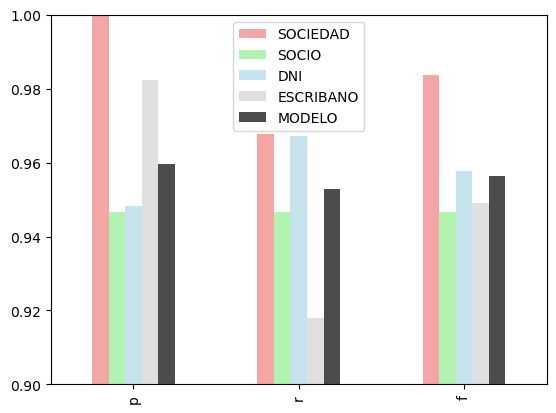

In [187]:
ents_per_type.plot.bar(ylim=(0.9,1),color=['lightcoral', 'lightgreen', 'lightblue','lightgray','black'], alpha=0.7)

In [95]:
def modelo_base(text,avoid_ls=None):
    avoid_ls = ['DATE', 'TIME', 'ORDINAL', 'CARDINAL']
    doc = nlp(text)
    ents = [(e.text, e.label_) for e in doc.ents if e.label_ not in avoid_ls]
    return ents

In [96]:
modelo_base(text)

[('Orlando DI FONZO', 'SOCIO'),
 ('Gonzalo Gastón DI FONZO', 'SOCIO'),
 ('Lucía Agundez', 'ESCRIBANO')]

# MODELO DE CLASIFICACION DE TEXTO

Para detectar constituciones societarias vs otras cosas

## acomodamos algunos datos mal imputados y creamos la marca 1 para estatutos

In [4]:
pip install --upgrade pandas

Note: you may need to restart the kernel to use updated packages.


In [7]:
anotados = pd.read_pickle('anotados.pkl')

In [8]:
len(anotados)

700

In [9]:
# cambios:
condition = anotados['Numbers'] == 'Estatuto'
anotados.loc[condition, 'Numbers'] = 1
# cambios 2
condition = anotados['Numbers'] == 'Otro'
anotados.loc[condition, 'Numbers'] = 0
anotados.head()

,Letters,Numbers
0,\nFLORIAN S.A.\n1) Daniel Mario Marquez DNI 10...,1
1,\nSOLUCIONES DE SEGURIDAD VIAL S.A.\nPor Asamb...,0
2,\nAVAPYME S.A.S.\nCONSTITUCIÓN: 17/10/2018. 1....,1
3,\nSHABBA FARMA S.R.L.\nEsc. 269 del 29-3-22 Re...,1
4,\nGADA GROUP S.A.\nCUIT 30-71583994-2. Por Act...,0


In [10]:
import re
# buscamos los valores que contienen la expresión "rectif" dentro del texto (posibles rectificaciones que se parecen mucho a un estatuto)
pattern = re.compile(r'\brectif[^\W_]*\b', re.IGNORECASE)
matching_indices = [index for index, value in anotados[anotados.Numbers==1]['Letters'].items() if re.search(pattern, value)]
# corregimos el valor de texto:
anotados.loc[matching_indices, 'Numbers'] = 0

In [263]:
#guardamos los valores corregidos
anotados.to_pickle('anotados.pkl')

----

## Entrenamiento de clasificacion de texto

https://medium.com/@johnidouglasmarangon/building-a-text-classification-model-with-spacy-3-x-57e59fa50547

In [8]:
!pip install unidecode

  Using cached Unidecode-1.3.8-py3-none-any.whl.metadata (13 kB)
Using cached Unidecode-1.3.8-py3-none-any.whl (235 kB)


In [9]:
import spacy
from spacy.lang.es.stop_words import STOP_WORDS
import string
from unidecode import unidecode
import os
path = r'C:\\Users\\juani\\Documents\\3_My_Jupiter_Notebooks\\0_github\\ner'
os.chdir(path)

In [12]:
np.__version__

'1.24.4'

In [10]:
!python --version


Python 3.8.18


In [11]:
anotados = pd.read_pickle('anotados.pkl')

In [12]:
import torch
print(torch.__version__)

2.2.0+cpu


In [16]:
# !python -m spacy download es_core_news_sm

In [17]:
nlp = spacy.load('es_core_news_sm')


In [18]:
# Load the spaCy model for Spanish
nlp = spacy.load('es_core_news_sm')

def preprocess(text):
    # Step 1: Lowercasing
    text = text.lower()
    text = unidecode(text)
    
    # Step 2: Tokenization
    doc = nlp(text)

    # Step 3: Stopword removal
    # tokens = [token.text for token in doc if token.text not in STOP_WORDS]
    #tokens = [token.text for token in doc if token.text not in STOP_WORDS and token.text not in string.punctuation]
    
    # Step 4: Lemmatization
    #lemmatized_tokens = [token.lemma_ for token in doc if token.text not in STOP_WORDS]
    lemmatized_tokens = [token.lemma_ for token in doc if token.text not in STOP_WORDS and token.text not in string.punctuation]


    return " ".join(lemmatized_tokens)

# Example usage:
text_example = "Este es un ejemplo de ,texto en español que queremos procesar."
preprocessed_tokens = preprocess(text_example)

print("Original Text:", text_example)
print("Preprocessed Tokens:", preprocessed_tokens)

Original Text: Este es un ejemplo de ,texto en español que queremos procesar.
Preprocessed Tokens: ejemplo texto espanol procesar


In [19]:
# !python -m spacy download es_core_news_sm

In [20]:
anotados['tokens'] = [preprocess(l) for l in anotados['Letters'] ]
anotados = anotados[['Letters', 'tokens', 'Numbers']]
anotados.head()

,Letters,tokens,Numbers
0,\nFLORIAN S.A.\n1) Daniel Mario Marquez DNI 10...,\n floriar s.a \n 1 daniel mario marquez dni 1...,1
1,\nSOLUCIONES DE SEGURIDAD VIAL S.A.\nPor Asamb...,\n solución seguridad vial s.a \n asamblea gen...,0
2,\nAVAPYME S.A.S.\nCONSTITUCIÓN: 17/10/2018. 1....,\n avapymir s.a.s \n constitucion 17/10/2018 1...,1
3,\nSHABBA FARMA S.R.L.\nEsc. 269 del 29-3-22 Re...,\n shabba farmar s.r.l \n esc 269 29-3-22 regi...,1
4,\nGADA GROUP S.A.\nCUIT 30-71583994-2. Por Act...,\n gado group s.a \n cuit 30-71583994-2 acta a...,0


In [21]:
anotados['tokens'].values[0]

'\n floriar s.a \n 1 daniel mario marquez dni 10788314 argentino divorciado comerciante 23/02/53 guillermo rawson 2715 \n localidad olivo partido vicente lopez pcia bs as suscribir 95 acción alberto rivera luna dni \n 18820133 argentino divorciado comerciante 06/01/68 av cobir 1581 car suscribir 5 acción \n nominativa endosabl 4000 valor nominal 1 voto accion 2 10/02/22 4 junin 1715 car \n 5 restaurante cafe bar salon evento 6 30 ano 7 400000 8) direccion administracion 1 7 director \n 3 ejercicio sindico 9 presidente presidente daniel mario marquez vicepresidente alberto rivera \n luna suplente gustavo marcelo graieb dni 14157635 argentino soltero productor seguro 14/05/60 av \n cabildo 1695 piso 8 depto 26 car domicilio especial sede social 10 30/06 autorizado \n instrumento publico esc 16 fecha 10/02/2022 reg 412 \n pablo damiar rodriguez tdeg 69 fdeg 84 c.p.a.c.f \n'

In [32]:
texts = anotados['tokens'].values
# train_labels = [{'cats': label}  for label in anotados['Numbers']]
labels = anotados['Numbers'].values

In [33]:
data = list(zip(texts, labels))
data[0]

('\n floriar s.a \n 1 daniel mario marquez dni 10788314 argentino divorciado comerciante 23/02/53 guillermo rawson 2715 \n localidad olivo partido vicente lopez pcia bs as suscribir 95 acción alberto rivera luna dni \n 18820133 argentino divorciado comerciante 06/01/68 av cobir 1581 car suscribir 5 acción \n nominativa endosabl 4000 valor nominal 1 voto accion 2 10/02/22 4 junin 1715 car \n 5 restaurante cafe bar salon evento 6 30 ano 7 400000 8) direccion administracion 1 7 director \n 3 ejercicio sindico 9 presidente presidente daniel mario marquez vicepresidente alberto rivera \n luna suplente gustavo marcelo graieb dni 14157635 argentino soltero productor seguro 14/05/60 av \n cabildo 1695 piso 8 depto 26 car domicilio especial sede social 10 30/06 autorizado \n instrumento publico esc 16 fecha 10/02/2022 reg 412 \n pablo damiar rodriguez tdeg 69 fdeg 84 c.p.a.c.f \n',
 1)

In [31]:
# 72% — train set: used to train the pipeline.
# 18% — dev set: used to evaluate the pipeline during the training interactions.
# 10% — test set: used to evaluate the final model.

In [34]:
# Split the annotated data into training and testing sets
from sklearn.model_selection import train_test_split
training, dev = train_test_split(data, test_size=0.1, random_state=42)
train, test = train_test_split(training, test_size=0.2, random_state=42)

# Display the number of items in the training and testing sets
len(train), len(test), len(dev)

(504, 126, 70)

In [40]:
(126)/(504 + 126+ 70)

0.18

In [ ]:
# !python -m spacy download es_core_news_sm

In [42]:
os.getcwd()

'C:\\Users\\juani\\Documents\\3_My_Jupiter_Notebooks\\0_github\\ner\\toy_classifier'

In [43]:
from spacy.tokens import DocBin
import spacy



path = r'C:\\Users\\juani\\Documents\\3_My_Jupiter_Notebooks\\0_github\\ner\\new'
os.chdir(path)


def convert(data, outfile):
    # spacy_model = 'es_core_news_sm'
    nlp = spacy.load("es_core_news_sm")  # es_core_news_sm /  es_dep_news_trf
    db = spacy.tokens.DocBin()
    docs = []
    for doc, label in nlp.pipe(data, as_tuples=True):
        doc.cats["POS"] = label == 1
        doc.cats["NEG"] = label == 0
        db.add(doc)
    
    db.to_disk(outfile)
convert(train, "./train.spacy")
convert(test, "./test.spacy")
convert(dev, "./dev.spacy")

In [29]:
!python -m spacy init fill-config C:\\Users\\juani\\Documents\\3_My_Jupiter_Notebooks\\0_github\\ner\\toy_classifier\\config.cfg

Usage: python -m spacy init fill-config [OPTIONS] BASE_PATH [OUTPUT_FILE]
Try 'python -m spacy init fill-config --help' for help.

Error: Invalid value for 'BASE_PATH': File 'C:\\\\Users\\\\juani\\\\Documents\\\\3_My_Jupiter_Notebooks\\\\0_github\\\\ner\\\\toy_classifier\\\\config.cfg' does not exist.


In [44]:
os.getcwd()

'C:\\Users\\juani\\Documents\\3_My_Jupiter_Notebooks\\0_github\\ner\\new'

In [30]:
!python -m spacy init fill-config C:\\Users\\juani\\Documents\\3_My_Jupiter_Notebooks\\0_github\\ner\\new\\base_config.cfg C:\\Users\\juani\\Documents\\3_My_Jupiter_Notebooks\\0_github\\ner\\new\\config.cfg

[+] Auto-filled config with all values
[+] Saved config
C:\Users\juani\Documents\3_My_Jupiter_Notebooks\0_github\ner\new\config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [49]:
# !python -m spacy download es_core_news_lg

In [55]:
os.getcwd()

'C:\\Users\\juani\\Documents\\3_My_Jupiter_Notebooks\\0_github\\ner\\new'

In [56]:
!python output_updated/model-best

python: can't open file 'output_updated/model-best': [Errno 2] No such file or directory


In [62]:
os.getcwd()

'C:\\Users\\juani\\Documents\\3_My_Jupiter_Notebooks\\0_github\\ner\\new'

In [63]:
!python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy --output ./best

[i] Saving to output directory: best
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'textcat']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS TEXTCAT  CATS_SCORE  SCORE 
---  ------  ------------  ------------  ----------  ------
  0       0          0.00          0.25       25.53    0.26
  0     200         20.00         54.69       81.03    0.81
  0     400         88.13         28.50       89.20    0.89
  1     600         89.63         31.53       30.25    0.30
  1     800        201.95         49.56       72.17    0.72
  2    1000        550.80         58.62       75.44    0.75
  2    1200        442.19         30.36       89.01    0.89
  2    1400        448.76         37.21       86.12    0.86
  3    1600       1744.95         27.66       89.20    0.89
  3    1800       1169.70         31.87

### LOAD MODEL

In [65]:
# Load the trained model
nlp = spacy.load('C:\\Users\\juani\\Documents\\3_My_Jupiter_Notebooks\\0_github\\ner\\new\\best\\model-best')

#### Performance

In [71]:
import warnings
# leavntamos los datos de performance:
d = nlp.__dict__['_meta']['performance']
# armamos un dataframe por variable:
cats_per_type = pd.DataFrame(d['cats_f_per_type'])
cats_per_type.round(2)

,POS,NEG
p,0.95,0.85
r,0.91,0.92
f,0.93,0.88


#### Example in Action

In [ ]:
import matplotlib.pyplot as plt

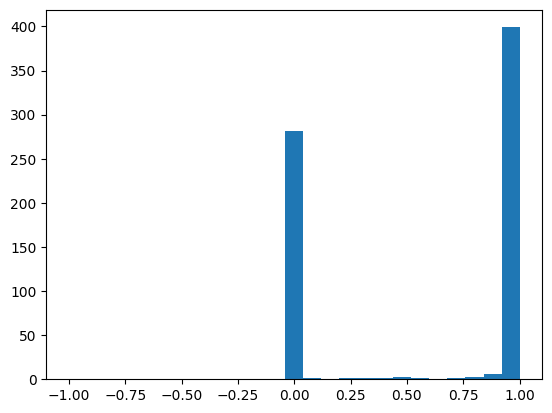

In [126]:
def get_proba(text=str):
    doc = nlp(text)
    return doc.cats['POS']


# test = anotados.tokens.tolist()

# proba_ls = [*map(get_proba, test)]

anotados['prob'] = proba_ls.copy()

_, bins = pd.cut(proba_ls, bins=25, retbins=True)
plt.hist(proba_ls, bins);

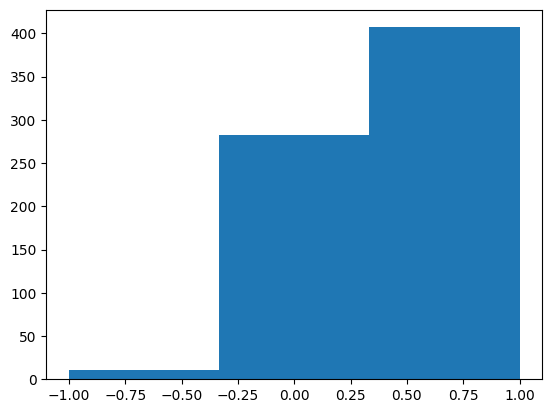

In [131]:
def discretize(p):
    if p<0.2:
        return 0
    elif p<0.8:
        return -1
    else:
        return 1

discretize_ls = [*map(discretize, proba_ls)]
anotados['pred'] = discretize_ls.copy()
_, bins = pd.cut(discretize_ls, bins=3, retbins=True)
plt.hist(discretize_ls, bins);

In [133]:
anotados['control'] = [ int(a==b) for a,b in zip( discretize_ls, anotados.Numbers.tolist())]

In [137]:
len(anotados[anotados['control']==0]) / 700*100

11.428571428571429

In [148]:
anotados.columns

Index(['Letters', 'tokens', 'Numbers', 'pred', 'prob', 'control'], dtype='object')

In [ ]:
eliminar si hay 2 o 3 interlinieados continuos: ==> \n\n\n\n

In [150]:
anotados[(anotados['control']==0)&(anotados['Numbers']==1)].tokens.tolist()[3]

'\n canasta juan s.r.l \n esc.ndeg  151 24/10/2018 reg 206 car socio 1 juan manuel roldan 38 ano soltero dni 31551316 \n cuit 20-31551316-3 domiciliado av francisco beiro 4955 car 2 irmar ín rey 56 ano viudo dni \n 18583127 cuit 27-18583127-8 domiciliado calle chile 2610 benavidez pdo tigre pciar bs as \n argentino comerciant denominacion canasta juan srl sede av francisco beiro 4955 car \n duracion 99 ano objeto sociedad objeto tercero asociado \n tercero pais extranjero menor elaboracion fabricacion venta distribucion \n\n\n\n \n comercializacion tipo producto panaderia reposteria pastelerio especialidad confiteria \n afín incluir bebida articulo caracter gastronomico vinculado objeto social \n tercero concesión franquicia tercero caso \n requerir sociedad contratar profesional titulo habilitante capital social 100000 dividido \n 100000 cuota 1 valor nominal c u. administracion representacion legal termino duracion \n sociedad composicion gerente juan manuel roldan aceptar cargo cons

In [147]:
print(anotados[(anotados['control']==0)&(anotados['Numbers']==1)].Letters.tolist()[3])


LA CANASTA DE JUAN S.R.L.
Esc.n° 151 del 24/10/2018 Reg 206 CABA, Socios: 1) Juan Manuel ROLDAN, 38 años, soltero, DNI 31.551.316, 
CUIT 20-31551316-3, domiciliado en Av. Francisco Beiró 4955 CABA; y 2) Irma Inés REYES, 56 años, viuda, DNI 
18.583.127, CUIT 27-18583127-8, domiciliada en la calle Chile 2610, Benavidez, Pdo. Tigre, Pcia Bs. As.; ambos 
argentinos, comerciantes. Denominación: LA CANASTA DE JUAN SRL. Sede: Av. Francisco Beiró 4955 CABA. 
Duración: 99 años. Objeto: La sociedad tiene por objeto realizar por cuenta propia, de terceros y/o asociada a 
terceros, en el país o en el extranjero, ya sea al por mayor y/o menor, a la elaboración, fabricación, venta, distribución 



 
y comercialización de todo tipo de productos de panadería, repostería y pastelería, y especialidades de confitería y 
afines, incluyendo bebidas y cualquier otro artículo de carácter gastronómico vinculado al objeto social, realizado 
por cuenta propia, mediante terceros y/o mediante concesiones y fran

In [144]:
for n,l in enumerate(anotados[(anotados['control']==0)&(anotados['Numbers']==1)].Letters):
    print(f'CASO {n}')
    print(l)
    print('----')

CASO 0
SOCIEDADES ANÓNIMAS
3 SM S.A.
Constituida por Esc. Nº 138 del 11/09/2019 por ante el registro 1480 de C.A.B.A.; Socios: José Luis ABOSO, nacido 
el 25/04/1973, D.N.I.: 23.251.275, casado en primeras nupcias con Verónica Milesi, empresario, con domicilio en 
Ayacucho 2662, Olivos, Vicente López, Pcia. de Bs. As.; Brian Axel TURRINI, nacido el 18/05/1979, D.N.I.: 27.282.306, 
casado en primeras nupcias con Laura Daniela De Llano, con domicilio en Bahía Blanca 3898, de C.A.B.A.; ambos 
argentinos y empresarios.- 1) Denominación: “3 SM S.A.”.- 2) Duración: 99 años.- 3) Objeto: dedicarse por cuenta 
propia, de terceros o asociada a terceros, dentro y fuera del país, a las siguientes actividades: Servicio Electrónico 
de Pagos mediante la Recaudación Electrónica de Fondos y/o Cobranzas por cuenta y orden de terceros.- Para 
el cumplimiento de su objeto la sociedad tiene plena capacidad jurídica para realizar todo tipo de actos, contratos 
u operaciones que se vinculen directa o indire

In [167]:
falsos_negativos_ls = anotados[(anotados['control']==0)&(anotados['Numbers']==1)].tokens.tolist()

In [168]:
import re

your_string = falsos_negativos_ls[-1]
cleaned_string = re.sub(r'\n\n\n\n', '', your_string)
get_proba(your_string), get_proba(cleaned_string)

(0.00015314096526708454, 0.00015285475819837302)

In [169]:
len(your_string.split(' '))

338

In [171]:
get_proba(cleaned_string[40:])

0.00016642791160847992

In [170]:
cleaned_string[40:]

'cent consulting s.r.l \n instrumento privado 08 marzo 2018 constituyo sociedad ascent consulting s.r.l 1 socio \n martin alejandro sommer argentino nacido 02/03/73 dni 23292171 casado empresario domiciliado laprida \n 2150 piso 9o departamento d car mauricio miguel gonzalez botto uruguayo nacido 515/05/68 dni \n 93944315 divorciado empresario domicilio o`higging 1414 piso 5o departamento 5 car 2 objeto \n sociedad objeto tercero asociado tercero pais exterior \n siguiente actividad consultoria asesoramiento servicio consultoria asesoramiento \n planeacion estrategico capacitacion optimizacion activo recurso planeacion inversión asesoria \n riesgo desarrollo organizacion empresarial sistema informacion comunicación recurso \n humano mercado infraestructura productivo servicio producto b representacion suscribir \n contrato representacion mandato agencia gestion negocio comision consignacion gerenciar \n administrar tipo servicio producto prestado empresa nacional extranjero c inmobilia

In [165]:
get_proba(cleaned_string[40:])

0.0001619480171939358

In [159]:
print(your_string)


SOCIEDADES DE RESPONSABILIDAD LIMITADA
ASCENT CONSULTING S.R.L.
Por instrumento privado del 08 de marzo de 2018 se constituyó la sociedad ASCENT CONSULTING S.R.L. 1) Socios: 
Martín Alejandro SOMMER, argentino, nacido 02/03/73, DNI 23292171, casado, empresario, domiciliado en Laprida 
2150, Piso 9º Departamento “D”, CABA, y Mauricio Miguel GONZÁLEZ BOTTO, uruguayo, nacido el 515/05/68, DNI 
93944315, divorciado, empresario, con domicilio en O`Higgings 1414, Piso 5º Departamento “5”, CABA; 2) Objeto: 
La sociedad tiene por objeto realizar por sí, por cuenta de terceros o asociada a terceros, en el país o en el exterior, 
las siguientes actividades: a) CONSULTORÍA Y ASESORAMIENTO: servicios de consultoría, asesoramiento, 
planeación estratégica, capacitación, y optimización de activos y recursos, planeación de inversiones y asesoría 
de riesgos, desarrollo de organización empresarial, sistemas de información y comunicaciones, de recursos 
humanos, de mercado, de infraestructura producti

In [132]:
check_ls = [ int(a==b) for a,b in zip( discretize_ls, anotados.Numbers.tolist())]
# check_ls

In [117]:
# anotados.Numbers.tolist()

In [114]:
len(discretize_ls)

700

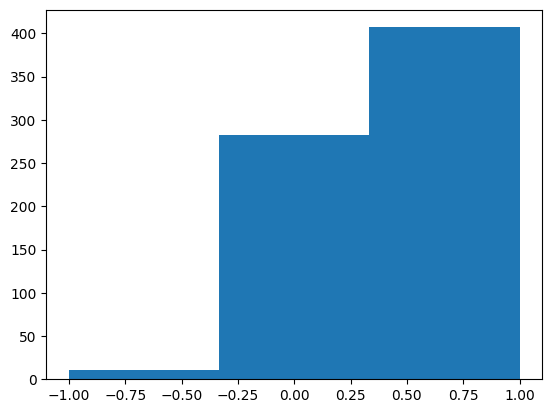

In [112]:
def discretize(p):
    if p<0.2:
        return 0
    elif p<0.8:
        return -1
    else:
        return 1

discretize_ls = [*map(discretize, proba_ls)]

_, bins = pd.cut(discretize_ls, bins=3, retbins=True)
plt.hist(discretize_ls, bins);

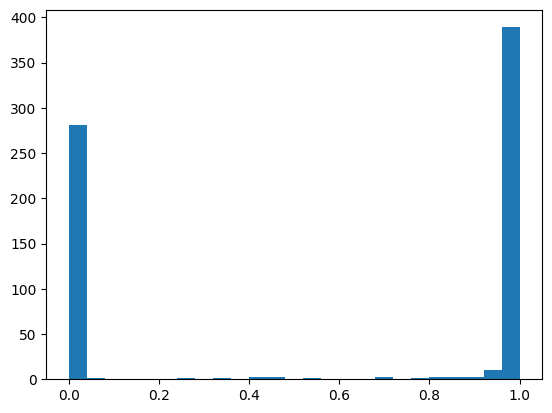

In [109]:
_, bins = pd.cut(proba_ls, bins=25, retbins=True)
plt.hist(proba_ls, bins);

In [ ]:
anotados

In [ ]:
def modelo_clasificacion_1(text):



# Load the spaCy model for Spanish
nlp = spacy.load('es_core_news_sm')

def preprocess(text):
    # Step 1: Lowercasing
    text = text.lower()
    text = unidecode(text)
    
    # Step 2: Tokenization
    doc = nlp(text)

    # Step 3: Stopword removal
    # tokens = [token.text for token in doc if token.text not in STOP_WORDS]
    #tokens = [token.text for token in doc if token.text not in STOP_WORDS and token.text not in string.punctuation]
    
    # Step 4: Lemmatization
    #lemmatized_tokens = [token.lemma_ for token in doc if token.text not in STOP_WORDS]
    lemmatized_tokens = [token.lemma_ for token in doc if token.text not in STOP_WORDS and token.text not in string.punctuation]


    return " ".join(lemmatized_tokens)

In [91]:
anotados['predicted

,Letters,tokens,Numbers
0,\nFLORIAN S.A.\n1) Daniel Mario Marquez DNI 10...,\n floriar s.a \n 1 daniel mario marquez dni 1...,1
1,\nSOLUCIONES DE SEGURIDAD VIAL S.A.\nPor Asamb...,\n solución seguridad vial s.a \n asamblea gen...,0
2,\nAVAPYME S.A.S.\nCONSTITUCIÓN: 17/10/2018. 1....,\n avapymir s.a.s \n constitucion 17/10/2018 1...,1
3,\nSHABBA FARMA S.R.L.\nEsc. 269 del 29-3-22 Re...,\n shabba farmar s.r.l \n esc 269 29-3-22 regi...,1
4,\nGADA GROUP S.A.\nCUIT 30-71583994-2. Por Act...,\n gado group s.a \n cuit 30-71583994-2 acta a...,0
...,...,...,...
695,\n\n\n \nESAOTE LATINOAMÉRICA S.A.U.\nCUIT N° ...,\n\n\n \n esaote latinoamerico s.a.u \n cuit n...,0
696,\nARQ & CO S.A.S.\nCONSTITUCIÓN: 07/08/2019. 1...,\n arq co s.a.s \n constitucion 07/08/2019 1.-...,1
697,\n\n\n \nEVENTOS TURISTICOS Y RURALES S.R.L.\n...,\n\n\n \n evento turistico rural s.r.l \n 1 16...,1
698,\nCALITEC S.R.L.\nPor resolucion de reunion de...,\n calitec s.r.l \n resolucion reunion socio 3...,0


In [90]:
Letters

NameError: name 'Letters' is not defined

---

In [ ]:

# Example text for prediction
new_text = test[10][0]# "Some new text that you want to classify."

# Process the text with the loaded model
doc = nlp(new_text)

# Access the text classification scores for each category
category_scores = doc.cats

# Predicted category with the highest score
predicted_category = max(category_scores, key=category_scores.get)

print(f"Predicted Category: {predicted_category}")
print("Category Scores:", category_scores)

In [53]:
# nlp.__dict__

In [128]:
print(spacy.__version__)


3.5.2


In [50]:
# python -m spacy init fill-config base_config.cfg config.cfg


In [39]:
text_cat.__dict__

{'_rehearsal_model': None}

In [37]:
evaluation_results = text_cat.evaluate(test)
print(evaluation_results)

AttributeError: 'TextCategorizer' object has no attribute 'evaluate'

In [26]:
import os
os.getcwd()

'C:\\Users\\juani\\Documents\\3_My_Jupiter_Notebooks\\0_github\\ner'

In [27]:
# Save the trained model
nlp.to_disk('C:\\Users\\juani\\Documents\\3_My_Jupiter_Notebooks\\0_github\\ner\\toy_classifier')

In [42]:
test[0][0]

'\n ltx argentino s.r.l \n cuit 30712087303 cumplimiento rg igj 3/2020 comunicar fecha 30/12/21 jorge damaso hector \n alcantar cedio 2400 cuota juan pedro alcantara b veronicar susana masle cedio 9000 cuota juan \n pedro alcantara c veronicar susana masle cedio 600 cuota dolor delfino quedar capital social \n 12000 representado 12000 cuota 1 valor nominal suscripto juan pedro alcantara \n argentino dni 28643594 cuit 20286435948 casado nacido 08/01/81 domicilio av constituyent 7245 \n benavidez tigre provincia aires 11400 cuota dolor delfino argentino dni 25288590 cuit \n 27252885906 casado nacido 18/06/76 domicilio av constituyent 7245 benavidez tigre provincia \n aires 600 cuota escritura fecha 30/12/21 jorge damaso hector alcantar renuncio cargo \n gerente designar reemplazo gerente juan pedro alcantara aceptar cargo constituir \n domicilio clemente zarraga 3561 car escritura fecha 30/12/21 reformo articulo 5 contrato \n social quedar articulo quinto administracion sociedad estar ca

In [48]:
import spacy

# Load the trained model
nlp = spacy.load('C:\\Users\\juani\\Documents\\3_My_Jupiter_Notebooks\\0_github\\ner\\toy_classifier')

# Example text for prediction
new_text = test[10][0]# "Some new text that you want to classify."

# Process the text with the loaded model
doc = nlp(new_text)

# Access the text classification scores for each category
category_scores = doc.cats

# Predicted category with the highest score
predicted_category = max(category_scores, key=category_scores.get)

print(f"Predicted Category: {predicted_category}")
print("Category Scores:", category_scores)

Predicted Category: estatuto
Category Scores: {'estatuto': 0.5, 'otro': 0.5}


In [47]:
category_scores

{'estatuto': 0.5, 'otro': 0.5}